Get data from sport-tracker diary/workout-list, filtered by walking and dates at 2017 start to end.
Copy corresponding div from browser development tools (chrome f12)
Save it as walks2017.html

In [1]:
file = 'walks2017.html'
html_doc = open(file, 'r').read()
#print(html_doc)


In [2]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_doc, 'html.parser')

#print(soup.prettify())

In [3]:
listat = soup.find_all('ul')

listat = listat[1]
sports = listat.find_all('li')
print("Total walks: %d" % (len(sports)))
    

Total walks: 229


In [4]:
sport_dict =list()

for st in sports:
    single_sport = list()
    for s in st.find_all('span'):
        if s.get('class')[0] == 'date':
            single_sport.append(s.contents[0])
        if s.get('class')[0] == 'distance':
            single_sport.append(s.contents[0].replace('km',''))
        if s.get('class')[0] == 'duration':
            single_sport.append(s.contents[0])
        if s.get('class')[0] == 'avg-speed':
            single_sport.append(s.contents[0].replace('km/h',''))
    
    sport_dict.append(single_sport)

import pandas as pd
df = pd.DataFrame(sport_dict)
df.columns = ['date', 'time', 'distance', 'avg-speed']
df.head()


,date,time,distance,avg-speed
0,"Dec 31, 2017",01:06:31,6.58,5.9
1,"Dec 30, 2017",01:01:27,3.87,3.8
2,"Dec 27, 2017",00:42:26,3.64,5.1
3,"Dec 26, 2017",01:14:09,4.45,3.6
4,"Dec 24, 2017",01:22:45,5.03,3.6


In [5]:
df.dtypes

date         object
time         object
distance     object
avg-speed    object
dtype: object

In [6]:
df['distance']=df['distance'].astype('float32')
df['avg-speed']=df['avg-speed'].astype('float32')
df.dtypes

date          object
time          object
distance     float32
avg-speed    float32
dtype: object

In [7]:
df['date'] = pd.to_datetime(df['date'])
#pd.to_datetime(df['date'])
df.dtypes

date         datetime64[ns]
time                 object
distance            float32
avg-speed           float32
dtype: object

## Write walks to csv, for future development

In [8]:
w = df.to_csv('walks.csv', index=False)

## Load csv and plot polynomial fits by dates

In [9]:
import pandas as pd
try:
    df = pd.read_csv('walks.csv')
except FileNotFoundError:
    print('Using old df')

# convert date to datetime64[ns]
df['date'] = pd.to_datetime(df['date'])
#pd.to_datetime(df['date'])
df.dtypes

date         datetime64[ns]
time                 object
distance            float64
avg-speed           float64
dtype: object

In [10]:
import matplotlib.pyplot as plt
import numpy as np
print("mean %.3f" % np.mean(df['avg-speed']))
print("std %.3f" % np.std(df['avg-speed']))
s = np.mean(df['avg-speed']) - 2*np.std(df['avg-speed'])
e = np.mean(df['avg-speed']) + 2*np.std(df['avg-speed'])

mean 4.792
std 1.201


In [11]:
# Remove outliers
dfs = df.loc[ (df['avg-speed'] < e)  &  (df['avg-speed'] > s)]
print(len(dfs))
dfs.head()

214


,date,time,distance,avg-speed
0,2017-12-31,01:06:31,6.58,5.9
1,2017-12-30,01:01:27,3.87,3.8
2,2017-12-27,00:42:26,3.64,5.1
3,2017-12-26,01:14:09,4.45,3.6
4,2017-12-24,01:22:45,5.03,3.6


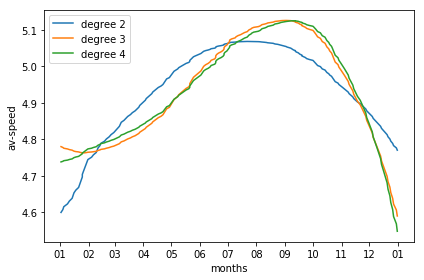

In [12]:
x = list(range(len(dfs['avg-speed'])))
date = list(dfs['date'])

import matplotlib.dates as mdates

months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%m')

fig, ax = plt.subplots()
for i in range(2,5):
    fit = np.polyfit(x, dfs['avg-speed'], deg=i)
    p = np.poly1d(fit)
    ax.plot(date, p(x), label=('degree %d' % i))

#plt.plot(date, dfs['avg-speed'], 'o')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)

plt.ylabel('av-speed')
plt.xlabel('months')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



## Load snowdepth from fmi

In [8]:
def get_fmi_url_1day(key, place, parameters, date='2017-01-01'):
    url = ('http://data.fmi.fi/fmi-apikey/{0}'
    +'/wfs?request=getFeature&storedquery_id=fmi::observations::weather::multipointcoverage&'
    +'place={1}&'
    +'parameters={2}&'
    +'starttime={3}T00:00:01Z&endtime={3}T23:59:59Z&'
    +'timestep=1440&').format(key, place, parameters, date)
    
    return url

In [9]:
#Lumensyvyys
#fmi-avain


key = '************************'
#avain = key
place = 'joensuu'
parameters = 'snowdepth'

url = get_fmi_url_1day(key, place, parameters)
#

# print(url)


In [10]:
import urllib3
manager = urllib3.PoolManager()
r = manager.request('GET', url)


In [11]:
data =r.data

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(data, 'xml')
#print(soup.prettify())

In [ ]:
s = soup.find('gml:doubleOrNilReasonTupleList')
sdepth = float(s.contents[0].replace('\n', ''))
sdepth

In [ ]:
dfs['date'][0].strftime(format='%Y-%m-%d')

In [ ]:
#len(dfs['date'])
import urllib3
from bs4 import BeautifulSoup

def parse_snow_depth(url):
    manager = urllib3.PoolManager()
    r = manager.request('GET', url)
    
    data =r.data
    
    soup = BeautifulSoup(data, 'xml')
    s = soup.find('gml:doubleOrNilReasonTupleList')
    try:
        return float(s.contents[0].replace('\n', ''))
    except AttributeError:
        return 0.0
        
    
def get_snow_depth(date):
    #print(date)
    date = date.strftime(format='%Y-%m-%d')
    key = '*****************'
    #avain = key
    place = 'joensuu'
    parameters = 'snowdepth'

    url = get_fmi_url_1day(key, place, parameters, date)
    return parse_snow_depth(url)

    
def get_snow_depths(dates):
    dd = list()
    for d in dates:
        dd.append(get_snow_depth(d))
    return dd
    

In [ ]:
df2 = dfs.copy()

In [ ]:
snowdepths = get_snow_depths(df2['date'])
df2 = df2.assign(snow= snowdepths)

In [ ]:
df2.head()

In [ ]:
ws = df2.to_csv('walks_snow.csv', index=False)

## Load walks with snow depth (walks_snow.csv)

In [22]:
import pandas as pd

try:
    df2 = pd.read_csv('walks_snow.csv')
except FileNotFoundError:
    print('No walks_snow file be here.\n'
        +'You should probably start from earlier blocks')
    

In [23]:
import pandas as pd

#def timedelta_to_hours(timedelta):
#    return timedelta.seconds/(60*60)

def time_col_to_hours(timec):
    """Changes timedelta column to float"""
    return pd.to_numeric(timec)/(60*60*1e9) #From milliseconds to hours

In [25]:
df2['date'] = pd.to_datetime(df2['date'])
df2['time'] = pd.to_timedelta(df2['time'])
df2['time'] = time_col_to_hours(df2['time'])

df2.dtypes


date         datetime64[ns]
time                float64
distance            float64
avg-speed           float64
snow                float64
dtype: object

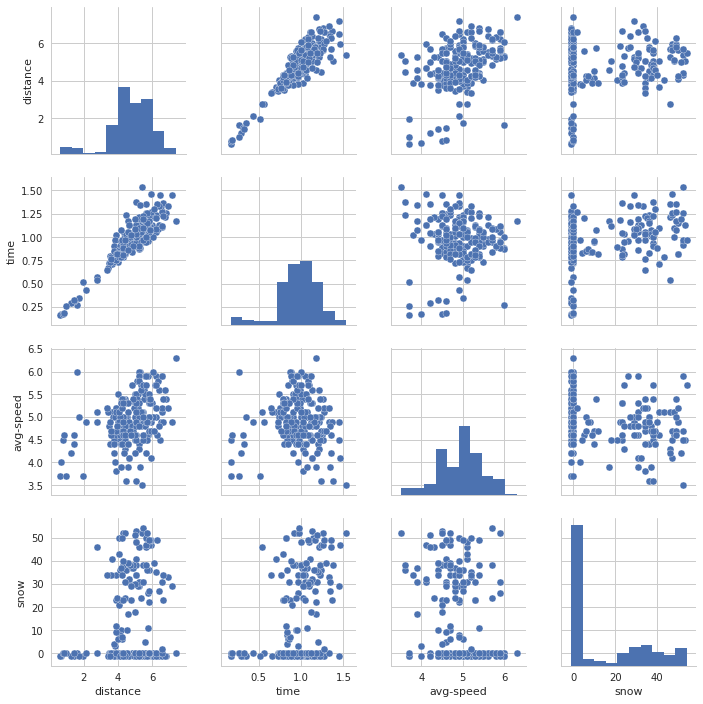

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['date', 'distance', 'time', 'avg-speed', 'snow']
sns.pairplot(df2[cols], size=2.5)
plt.show()

In [4]:
#sns.reset_orig()
#%matplotlib inline

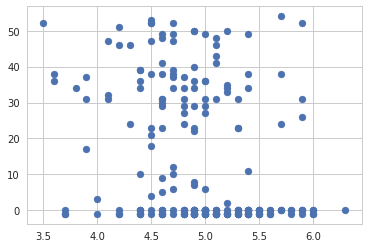

In [27]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(x = df2['avg-speed'], y = df2['snow'], marker='o')
plt.show()

In [28]:
print(np.mean((df2.loc[df2['snow'] < 1])['avg-speed']))
print(np.mean((df2.loc[df2['snow'] >= 1])['avg-speed']))

5.086440698575165
4.752083318928878


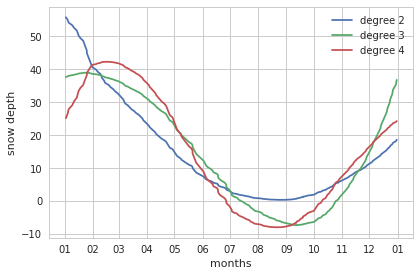

In [29]:
x = list(range(len(df2['snow'])))
date = list(df2['date'])

import matplotlib.dates as mdates

months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%m')

fig, ax = plt.subplots()
for i in range(2,5):
    fit = np.polyfit(x, df2['snow'], deg=i)
    p = np.poly1d(fit)
    ax.plot(date, p(x), label=('degree %d' % i))
    

#plt.plot(date, dfs['avg-speed'], 'o')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)

plt.ylabel('snow depth')
plt.xlabel('months')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [30]:
df2.sort_values(by=['avg-speed'])[:10]

,date,time,distance,avg-speed,snow
164,2017-04-03,1.532222,5.38,3.5,52.0
3,2017-12-26,1.235833,4.45,3.6,36.0
4,2017-12-24,1.379167,5.03,3.6,38.0
69,2017-09-09,0.517222,1.94,3.7,-1.0
116,2017-06-18,0.168056,0.62,3.7,-1.0
132,2017-05-23,0.263611,0.97,3.7,0.0
1,2017-12-30,1.024167,3.87,3.8,34.0
188,2017-02-11,1.072500,4.15,3.9,37.0
17,2017-12-02,1.176389,4.58,3.9,17.0
202,2017-01-23,1.344167,5.26,3.9,31.0


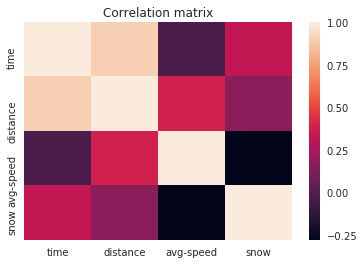

In [32]:
corr = df2.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.title('Correlation matrix')
plt.show()

## Remove no-snows???

In [38]:
df3 = df2.loc[df2['snow'] > 1]
print("Yes snows % d" % len(df3))
df3.head()


Yes snows  96


,date,time,distance,avg-speed,snow
0,2017-12-31,1.108611,6.58,5.9,31.0
1,2017-12-30,1.024167,3.87,3.8,34.0
2,2017-12-27,0.707222,3.64,5.1,41.0
3,2017-12-26,1.235833,4.45,3.6,36.0
4,2017-12-24,1.379167,5.03,3.6,38.0


In [39]:
df3.dtypes

date         datetime64[ns]
time                float64
distance            float64
avg-speed           float64
snow                float64
dtype: object

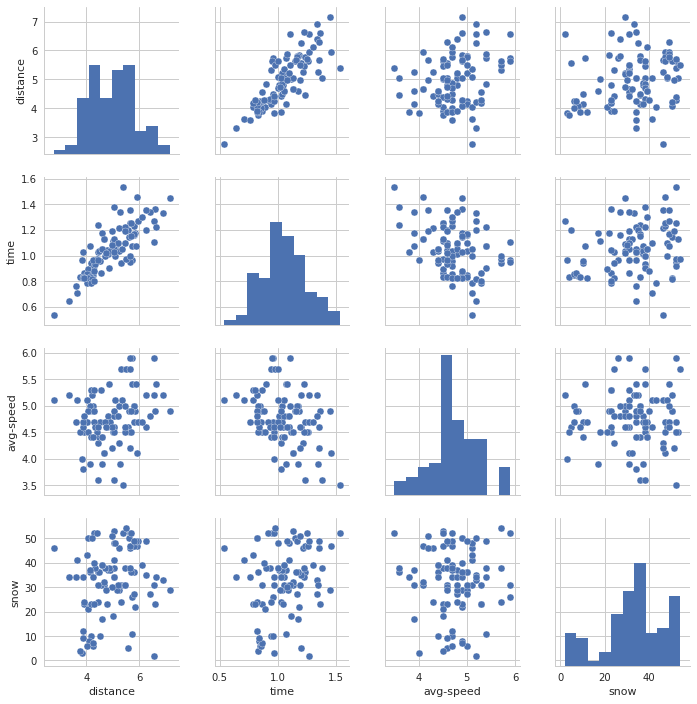

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['date', 'distance', 'time', 'avg-speed', 'snow']
sns.pairplot(df3[cols], size=2.5)
plt.show()

In [ ]:
It seems that snow depth has not much effect to average speed, distance or time.
That may be because not all those who wander are lost in the snow, but more likely walk on 
cleaned roads.

So I should filter the data to routes where there is not winter